In [1]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import tritonclient.grpc as grpcclient
from tqdm.auto import tqdm
from dotenv import load_dotenv
import random
import ipyplot

from utils import *

load_dotenv()

True

In [2]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
)

model_config = triton_client.get_model_config(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
).config

input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]

In [3]:
filenames = index_directory(IMAGE_FOLDER)

Indexed 15,814 file(s) in 0.192 seconds.


In [4]:
file_size = []
for file in tqdm(filenames):
    file_size.append(os.path.getsize(file))
avg_size = sum(file_size) / len(file_size) * 1e-6
print("Average image filesize ~{:.3f}MB.".format(avg_size))

  0%|          | 0/15814 [00:00<?, ?it/s]

Average image filesize ~3.702MB.


/usr/local/lib/python3.8/dist-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



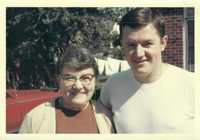
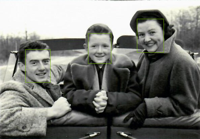
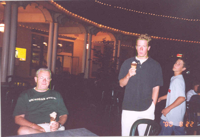
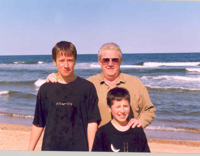
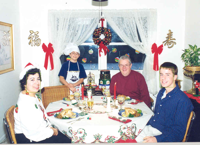
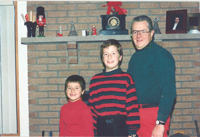
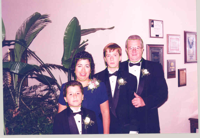
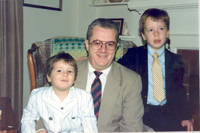


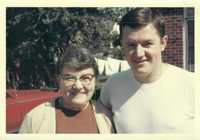
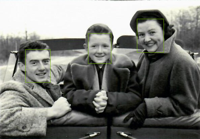
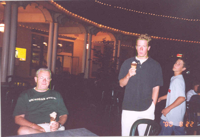
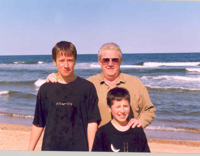
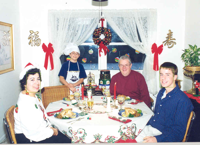
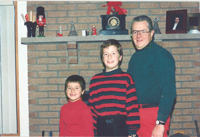
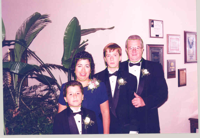
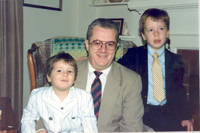

In [5]:
n = 0
max_images = 8
show_me_grid = []
show_me_labels = []
for filename in filenames:
    if n <= max_images:
        try:
            infer_result = submit_to_facedetect(
                filename, input_names, output_names, request_id=filename
            )
            if len(infer_result.as_numpy(output_names[1])) != 0:
                image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(
                    -1, 4
                )
                img = render_image(
                    filename, image_wise_bboxes, linewidth=10, output_size=200
                )
                show_me_grid.append(img)
                show_me_labels.append(
                    "{} face(s) found in {}".format(
                        len(infer_result.as_numpy(output_names[1])), filename
                    )
                )
                n += 1

        except Exception as e:
            print("There was an exception: {}.".format(e))
    else:
        break

ipyplot.plot_images(
    show_me_grid,
    labels=show_me_labels,
    max_images=max_images,
    img_width=400,
    show_url=False,
)

In [6]:
## DEBUG?
# facedetect_data = random.sample(facedetect_data, N_DEBUG)

In [ ]:
pbar = tqdm(
    total=len(filenames),
    desc="Submitting photos to {} at {}".format(
        FACE_DETECT_MODEL_NAME, TRITON_SERVER_URL
    ),
)

futures = []
results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(filenames, THREAD_CHUNKS):
        futures = []
        for filename in chunk:
            pbar.update()
            futures.append(
                executor.submit(
                    submit_to_facedetect, filename, input_names, output_names, filename
                )
            )

        for future in as_completed(futures):
            try:
                infer_result = future.result()
                results.append(infer_result)
            except Exception as e:
                print(
                    "There was an exception: {}\n{}.".format(
                        e, infer_result.get_response().id
                    )
                )

Submitting photos to facenet_ensemble at 172.25.4.42:8001:   0%|          | 0/15814 [00:00<?, ?it/s]

There was an exception: image file is truncated (30 bytes not processed)
/data/photos/2015-wedding-moose-photos/ab_hawk_hollow_wedding_lansing-459.jpeg.


In [ ]:
results_json_list = []
for infer_result in tqdm(results, desc="Parsing Inference Results"):
    result = {}
    this_id = infer_result.get_response().id
    image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(-1, 4)
    image_probas = infer_result.as_numpy(output_names[1]).reshape(-1, 1)
    result["filename"] = this_id
    result["faces"] = [{"bbox": {"x1": 0, "y1": 0, "x2": 0, "y2": 0}, "probability": 0}]
    for bbox, proba in zip(image_wise_bboxes, image_probas):
        result["faces"] = [
            {
                "bbox": {
                    "x1": bbox[0],
                    "y1": bbox[1],
                    "x2": bbox[2],
                    "y2": bbox[3],
                },
                "probability": proba[0],
            }
            for bbox, proba in zip(image_wise_bboxes, image_probas)
        ]

    results_json_list.append(result)

with open(JSON_DATA_FILE, "w") as f:
    json.dump(results_json_list, f, default=to_serializable_int)
print(len(results_json_list))

___